Import necessary libraries

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [51]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [52]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

In [53]:
class CancerCNN(nn.Module):
    def __init__(self):
        super(CancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1024 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(-1, 1024 * 7 * 7)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

Hyperparameters

In [54]:
image_size = 224
rotation = 10
normalization_mean = [0.5, 0.5, 0.5]
normalization_std = [0.5, 0.5, 0.5]

learning_rate = 0.05
batch_size = 4
epochs = 5

Image processing steps and data augmentation

In [55]:
train_transform = transforms.Compose([
    # Randomly rotate the image
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    # Randomly flip the image horizontally
    transforms.RandomHorizontalFlip(),
    # Randomly apply distortions
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    # Randomly apply affine transforms
    transforms.RandomAffine(degrees=15, scale=(
        0.9, 1.1), shear=10, translate=(0.1, 0.1)),
    # Randomly apply Gaussian blur
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(normalization_mean, normalization_std)
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(normalization_mean, normalization_std)
])

In [56]:
# Load the dataset
train_dataset = datasets.ImageFolder('data/train', transform=train_transform)
test_dataset = datasets.ImageFolder('data/test', transform=test_transform)

Define the loss function and optimizer

In [57]:
model = CancerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [58]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

Train The model

In [59]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []
f1_scores = []
best_f1_score = 0.0
best_model = None
patience_counter = 0
patience = 5

for epoch in range(epochs):
    train_loss = 0
    train_correct = 0
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    train_accs.append(train_acc)

    # Test the model
    model.eval()
    test_loss = 0
    test_correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            test_correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc = 100. * test_correct / len(test_loader.dataset)
    test_accs.append(test_acc)

    # Calculate F1 score
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    f1 = f1_score(all_targets, all_preds, average='macro')
    f1_scores.append(f1)

    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%, F1 score: {:.4f}'
          .format(epoch+1, epochs, train_loss, train_acc, test_loss, test_acc, f1))

    # Early stopping
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(
                'Early stopping: F1 score did not improve for {} epochs.'.format(patience))
            break
print('Best F1 score: {:.4f}'.format(best_f1_score))

Epoch [1/5], Train Loss: 0.1601, Train Acc: 63.25%, Test Loss: 0.1831, Test Acc: 75.00%, F1 score: 0.7445
Epoch [2/5], Train Loss: 0.1340, Train Acc: 74.06%, Test Loss: 0.1278, Test Acc: 74.85%, F1 score: 0.7437
Epoch [3/5], Train Loss: 0.1185, Train Acc: 76.83%, Test Loss: 0.1066, Test Acc: 78.48%, F1 score: 0.7839
Epoch [4/5], Train Loss: 0.1156, Train Acc: 76.94%, Test Loss: 0.1022, Test Acc: 79.39%, F1 score: 0.7927
Epoch [5/5], Train Loss: 0.1084, Train Acc: 78.46%, Test Loss: 0.0994, Test Acc: 79.85%, F1 score: 0.7965
Best F1 score: 0.7965


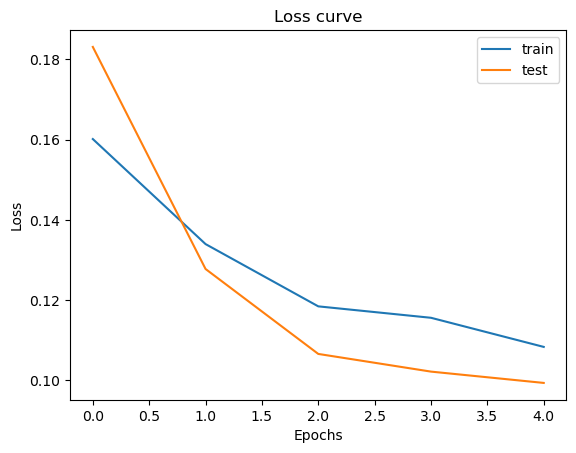

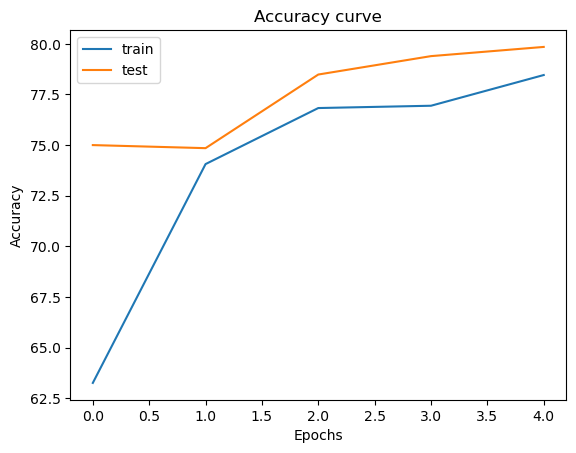

In [60]:
# Plot loss and accuracy curves
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.title('Accuracy curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Save the model

In [61]:
torch.save(model.state_dict(), 'cancer_cnn.pth')